In [1]:
# Import SQLAlchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine,inspect, func, desc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

#Dependencies for analysis
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Create engine & connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)
conn = engine.connect()

In [3]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# Map measurement and station classes (saving references)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# create a session
session = Session(engine)

# Precipitation Analysis

In [6]:
# Retrieve the last 12 months of precipitation data
# query to retreieve latest date
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#query to retrieve 365 days from lastest_date
first_date = dt.date(2017,7, 23) - dt.timedelta(days=365)

one_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()

In [7]:
# Creating dataframe
precipitation_df = pd.DataFrame(one_year_precipitation, columns=['Date', 'Precipitation'])
# precipitation_df.head()

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Get the total for each station for each date and set the index as the date.
total_precipitation = precipitation_df.pivot_table(precipitation_df, index=['Date'], aggfunc='mean')
total_precipitation.head()
# precipitation_df.dtypes

,Precipitation
Date,
2016-07-24,0.732000
2016-07-25,5.970000
2016-07-26,0.156667
2016-07-27,0.020000
2016-07-28,0.008333


C:\Users\palwinder\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


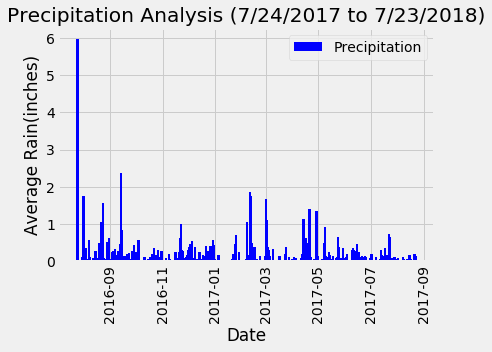

<Figure size 864x432 with 0 Axes>

In [8]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
style.use('fivethirtyeight')

plt.bar(total_precipitation.index, total_precipitation["Precipitation"], width=2.5, color="blue")
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Date")
plt.ylabel("Average Rain(inches)")
plt.title("Precipitation Analysis (7/24/2017 to 7/23/2018)")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.show()
plt.savefig("Images/Precipitation_Analysis.png")

In [9]:
#Summary Statistics
total_precipitation.describe()

,Precipitation
count,396.000000
mean,0.193526
std,0.420711
min,0.000000
25%,0.010000
50%,0.073667
75%,0.204000
max,5.970000


# Station Analysis

In [10]:
#Find the total number of stations
total_stations = session.query(Station.station).count()
print("There are a total of:" + " " + str(total_stations) + " " + "stations")

There are a total of: 9 stations


In [11]:
# What are the most active stations?
# List the stations and the counts in descending order.
# Query to find observation counts by station
station_tobs = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc())

# Printing observations
for station in station_tobs:
    print(station)
    
# Storing station name
top_station = station_tobs[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [12]:
#Which station has the highest number of observations?
max_observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc()).first()
for station in max_observations:
    print(station)

USC00519281
2772


In [13]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
station_12months = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > first_date).\
                    order_by(func.count(Measurement.tobs).desc()).all()

busiest_station = station_12months[0][0:2]   

print("The stations with the highest number of observations in the last 12 months in descending order are:")
print()
for station, name, count in station_12months:
    print("Station:",station, "in",name,"with",count, "observations.")

The stations with the highest number of observations in the last 12 months in descending order are:

Station: USC00519397 in WAIKIKI 717.2, HI US with 391 observations.
Station: USC00519281 in WAIHEE 837.5, HI US with 382 observations.
Station: USC00516128 in MANOA LYON ARBO 785.2, HI US with 379 observations.
Station: USC00513117 in KANEOHE 838.1, HI US with 373 observations.
Station: USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US with 367 observations.
Station: USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US with 327 observations.
Station: USC00517948 in PEARL CITY, HI US with 200 observations.


In [14]:
# TOBS = Temperature OBServation 
# Filter by the station with the highest number of observations.
highest_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station[0]).\
    filter(Measurement.date > first_date).\
    order_by(Measurement.date).all()

#DataFrame. 
highest_obs_df = pd.DataFrame(highest_obs, columns=['Date', 'Tobs'])
highest_obs_df.head()

,Date,Tobs
0,2016-07-24,79.0
1,2016-07-25,78.0
2,2016-07-26,80.0
3,2016-07-27,80.0
4,2016-07-28,80.0


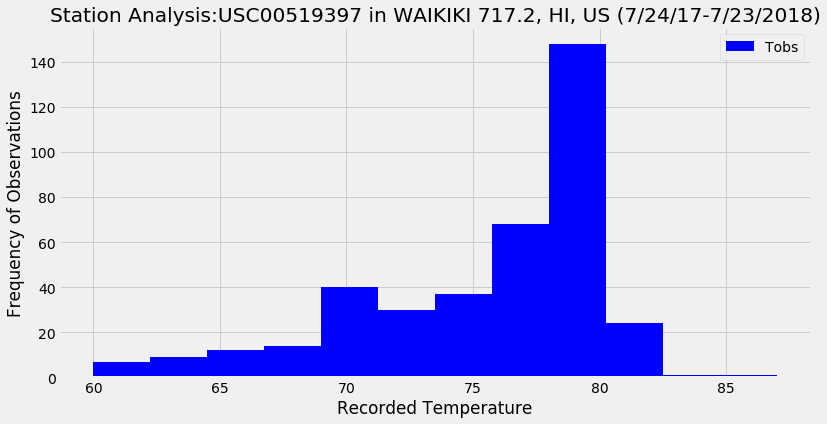

<Figure size 720x432 with 0 Axes>

In [15]:
#Histograph
plt.hist(highest_obs_df['Tobs'], bins=12, color = 'blue')
plt.rcParams['figure.figsize'] = [10,6]
plt.xlabel('Recorded Temperature')
plt.ylabel('Frequency of Observations')
plt.title("Station Analysis:USC00519397 in WAIKIKI 717.2, HI, US (7/24/17-7/23/2018)")
plt.legend(['Tobs'])
plt.show()
plt.savefig("Images/Station_Analysis.png")

# Temperature Analysis

In [16]:
#Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using
#the matching dates from the previous year

# Convering to date time
def calc_temps(start_date, end_date):
    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start_date). filter(Measurement.date <= end_date). all()
    
    for Min_temp, Max_temp, Avg_temp in query:
        print("From", start_date, "to", end_date, "the minimum temperature is",Min_temp, '\u00b0'"F, the maximum temperature is",
              Max_temp, '\u00b0'"F.")
# 15 day vacation
calc_temps('2017-07-01', '2017-07-15')

From 2017-07-01 to 2017-07-15 the minimum temperature is 69.0 °F, the maximum temperature is 87.0 °F.


In [17]:
start_date = '2017-07-01'
end_date = '2017-07-15'

vacation_2017 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#put it in a dataframe

Vacation_temperatures = pd.DataFrame(vacation_2017, columns=['Date', 'Tobs'])
Vacation_temperatures.head()

,Date,Tobs
0,2017-07-01,80.0
1,2017-07-02,80.0
2,2017-07-03,78.0
3,2017-07-04,80.0
4,2017-07-05,80.0


In [18]:
# obtaining whisker box elements
Vacation_temperatures.describe()

,Tobs
count,92.000000
mean,78.250000
std,2.850198
min,69.000000
25%,77.000000
50%,79.000000
75%,80.000000
max,87.000000


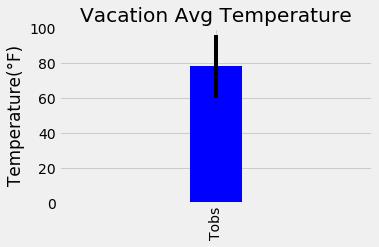

<Figure size 720x432 with 0 Axes>

In [19]:
#Whisker Box 
avg_temp = Vacation_temperatures.mean()
temperature_range = (Vacation_temperatures['Tobs'].max() - Vacation_temperatures['Tobs'].min())

p = avg_temp.plot(legend = False, kind = 'bar', color = 'blue', yerr = temperature_range,
                 width = 0.1, figsize = (5,3))
p.set_title("Vacation Avg Temperature")
p.set_ylabel("Temperature(°F)")
p.set_ylim(0,100)
plt.show()
plt.savefig("Images/Avg_Temperature_Analysis.png")